In [1]:
import sys
import pandas as pd
import random

from unpast.utils.method import zscore, prepare_input_matrix
from unpast.utils.io import read_bic_table, write_bic_table
from unpast.utils.consensus import make_consensus_biclusters

import sys
sys.path.insert(0, '..')
%matplotlib inline

In [2]:
in_dir = "results_on_real_data_tuned_v2/TCGA_optimized/"
out_dir = "results_on_real_data_tuned_v2/TCGA_optimized/"
dataset = 'TCGA-BRCA'

exprs_file_t = "data/preprocessed_v6/TCGA-BRCA_1079_17Kgenes.Xena_TCGA_PanCan.log2_exprs_z_v6.tsv"
exprs_t= pd.read_csv(exprs_file_t,sep = "\t",index_col=0)

suffix  = ".bin=kmeans,pval=0.01,clust=WGCNA,direction=DOWN-UP,ds=3,dch=0.995,max_power=10,precluster=True.biclusters.tsv" 

In [3]:
n_runs = 5
cseed = 42 # seed for consensus of 5 runs
seeds = []
random.seed(cseed)
for i in range(n_runs):
    seeds.append(random.randint(0,1000000))
print("generate ",n_runs," seeds",seeds)

generate  5  seeds [670487, 116739, 26225, 777572, 288389]


In [4]:
# reading biclusters detected in independent runs
biclustering_results = []
for seed in seeds:
    biclusters = read_bic_table(in_dir+dataset+".seed="+str(seed)+suffix)
    print("seed %s n biclusters: %s"%(seed,biclusters.shape[0]))
    # reindexing
    biclusters.index = ["seed="+str(seed)+"_"+str(x) for x in biclusters.index.values ]
    biclustering_results.append(biclusters)


seed 670487 n biclusters: 168
seed 116739 n biclusters: 197
seed 26225 n biclusters: 150
seed 777572 n biclusters: 134
seed 288389 n biclusters: 210


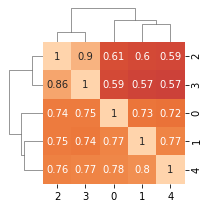

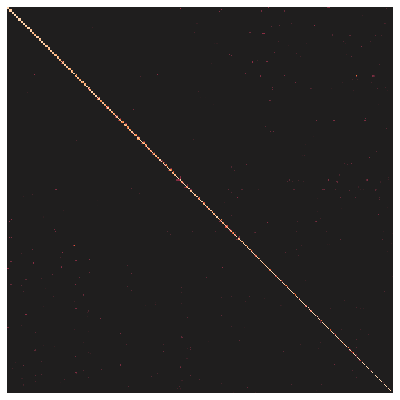

47 s for similarity matrix
	Running Louvain ...
		modularity: potts
	curve type: increasing


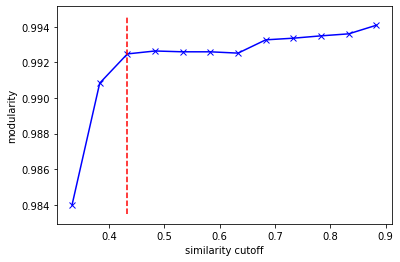

	Louvain runtime: modules detected in 0.85 s.
	modules: 210, not clustered features 86 
		similarity cutoff: 0.43 modularity: 0.992
keep genes included in at least 2 merged biclusters
all consensus biclusters: 296
detected 2+ times:208
14 s for making consensus biclusters from consensus gene sets


In [5]:
consensus_biclusters = make_consensus_biclusters(biclustering_results, 
                                                 zscore(exprs_t),
                                                 seed = cseed,
                                                 verbose = True,
                                                 plot = True)

In [6]:
outfname = out_dir+"/"+dataset+".consensus_v2_seed="+str(cseed)+suffix
print(outfname)
write_bic_table(consensus_biclusters, outfname)

results_on_real_data_tuned_v2/TCGA_optimized//TCGA-BRCA.consensus_v2_seed=42.bin=kmeans,pval=0.01,clust=WGCNA,direction=DOWN-UP,ds=3,dch=0.995,max_power=10,precluster=True.biclusters.tsv


# Evaluating performance
### TCGA

In [7]:
from unpast.utils.eval import make_ref_groups
from unpast.utils.eval import calculate_perfromance
# TCGA
t_subtypes = pd.read_csv("data/preprocessed_v6/TCGA-BRCA_1079_17Kgenes.Xena_TCGA_PanCan.subtypes_and_signatures_v6.tsv",sep = "\t",index_col=0)
t_annotation = pd.read_csv("data/preprocessed_v6/TCGA-BRCA_1079.Xena_TCGA_PanCan.annotation_v6.tsv",sep = "\t",index_col=0)

known_groups_t, all_samples_t = make_ref_groups(t_subtypes, t_annotation,exprs_t)


In [8]:
t_subtypes.head(2)

,PAM50,claudin_low,SCMOD2,SCMOD1,intClust,AIMS,AURKA,ESR1,ERBB2,Desmedt2008_ESR1,...,OncotypeDx_risk,GGI,TAMR13,GENE70,GENE70_risk,PIK3CA,rorS,rorS_risk,NET_km,NET_w
sample_id,,,,,,,,,,,,,,,,,,,,,
TCGA-3C-AAAU-01,LumB,0,ER+/HER2- High Prolif,ER+/HER2- High Prolif,2,LumB,9.7389,12.5624,13.6124,3.164715,...,1.0,6.860194,-34.292741,-0.125612,1,2.104245,51.803917,2,1,0
TCGA-3C-AALI-01,Her2,0,HER2+,HER2+,1,Her2,10.6689,7.1768,18.4282,2.287569,...,1.0,7.559643,-35.462394,-0.009592,1,2.304907,93.869507,3,0,0


In [9]:
t_annotation.head(2)

,age,stage,OS,OS.time,DSS,DSS.time,DFI,DFI.time,PFI,PFI.time,stage_2,stage_3,stage_4,IHC_ER,IHC_HER2,IHC_PR,IHC_TNBC
sample_id,,,,,,,,,,,,,,,,,
TCGA-3C-AAAU-01,55.0,NaN,0.0,4047.0,0.0,4047.0,1.0,1808.0,1.0,1808.0,NaN,NaN,NaN,Positive,Negative,Positive,0.0
TCGA-3C-AALI-01,50.0,2.0,0.0,4005.0,0.0,4005.0,0.0,4005.0,0.0,4005.0,1.0,0.0,0.0,Positive,Positive,Positive,0.0


In [10]:
performances, best_matches = calculate_perfromance(consensus_biclusters, known_groups_t,all_samples_t,
                                                  performance_measure="ARI")
performances

PAM50          0.723389
Intrinsic      0.699051
PAM50_AB       0.472755
SCMOD2         0.485605
IHC            0.505737
Luminal        0.717999
Basal          0.938534
Her2           0.559805
LumA           0.465327
LumB           0.206061
Normal         0.089773
Claudin-low    0.115465
IHC_HER2       0.453328
IHC_ER         0.586139
IHC_PR         0.424782
IHC_TNBC       0.505250
NET_kmeans     0.770237
NET_ward       0.715634
dtype: float64

In [11]:
best_matches.head()

,bm_id,ARI,weight,adj_pval,is_enriched,samples,n_samples,classification
Basal,2,0.938534,0.180723,0.000335,True,"{TCGA-LL-A8F5-01, TCGA-AN-A0FX-01, TCGA-B6-A0I...",195,PAM50
Normal,21,0.089773,0.029657,0.000162,True,"{TCGA-LL-A8F5-01, TCGA-AN-A0FX-01, TCGA-B6-A0I...",193,PAM50
Her2,22,0.559805,0.100093,0.000148,True,"{TCGA-AR-A0TQ-01, TCGA-A8-A08B-01, TCGA-C8-A13...",118,PAM50
Luminal,11,0.717999,0.689527,0.0006,False,"{TCGA-LL-A8F5-01, TCGA-AN-A0FX-01, TCGA-B6-A0I...",266,PAM50
Basal,2,0.938534,0.173488,0.000335,True,"{TCGA-LL-A8F5-01, TCGA-AN-A0FX-01, TCGA-B6-A0I...",195,Intrinsic


In [12]:
color_dict = {"PAM50":{'Basal':"lightblue", 'Her2':"yellow", 
                       'LumA':"lightgreen", 'LumB':"darkgreen", 
                       'Normal':"grey"}
             }

### Her2, Basal, Luminal

Standardized expressions will be limited to [-3,3]:


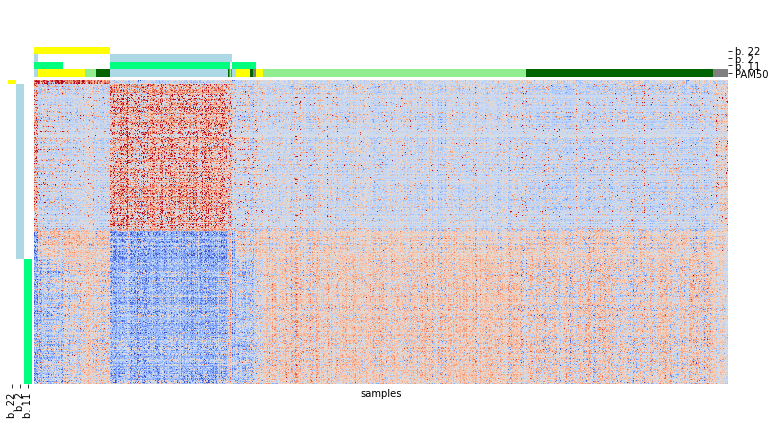

In [13]:
from unpast.utils.figs import draw_heatmap2

bm = best_matches.loc[best_matches["classification"]=="PAM50",:]
i = [bm.loc["Her2","bm_id"],bm.loc["Basal","bm_id"],bm.loc["Luminal","bm_id"]]

tmp = draw_heatmap2(prepare_input_matrix(exprs_t, min_n_samples=5,ceiling=3),
                    consensus_biclusters.loc[i,:],
                    annot = t_subtypes.loc[:,["PAM50"]],
                    color_dict= color_dict,
              bicluster_colors=["yellow","lightblue","springgreen"],#"redblue",#["magenta","orange","darkgreen","lightgreen"],
              figsize = (12,6), 
              dendrogram_ratio=(0.1,0.1), 
              colors_ratio=(0.02/12*6, 0.02),
              bic_prefix = "b. ",
              no_legend=True,no_cbar=True,
              col_labels = False,
              row_labels = False,
                no_row_colors = False,cluster_rows=False
             )

#plt.savefig("img/TCGA_consensus_PAM50_bestmatches.biclusters.png")

### Normal-like, LumA, LumB

Standardized expressions will be limited to [-3,3]:


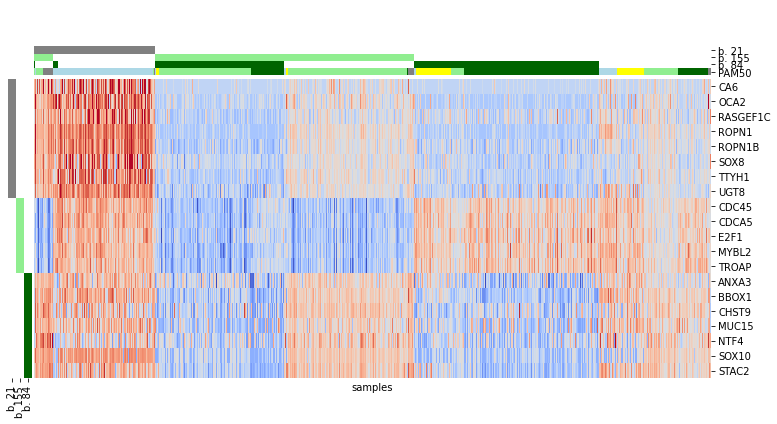

In [14]:
bm = best_matches.loc[best_matches["classification"]=="PAM50_AB",:]
i = [bm.loc["Normal","bm_id"],bm.loc["LumA","bm_id"],bm.loc["LumB","bm_id"]]

tmp = draw_heatmap2(prepare_input_matrix(exprs_t, min_n_samples=5,ceiling=3),
                    consensus_biclusters.loc[i,:],
                    annot = t_subtypes.loc[:,["PAM50"]],
                    color_dict= color_dict,
              bicluster_colors=["grey","lightgreen","darkgreen"],#"redblue",#["magenta","orange","darkgreen","lightgreen"],
              figsize = (12,6), 
              dendrogram_ratio=(0.1,0.1),
              colors_ratio=(0.02/12*6, 0.02),
              bic_prefix = "b. ",
              no_legend=True,no_cbar=True,
              col_labels = False,
              row_labels = True,
                no_row_colors = False,cluster_rows=False
             )

### METABRIC

In [15]:
in_dir = "results_on_real_data_tuned_v2/METABRIC_optimized/"
out_dir = "results_on_real_data_tuned_v2/METABRIC_optimized/"
dataset = 'METABRIC'
exprs_file = "data/preprocessed_v6/METABRIC_1904_17Kgenes.log2_exprs_z_v6.tsv"

suffix  = ".bin=kmeans,pval=0.01,clust=WGCNA,direction=DOWN-UP,ds=3,dch=0.995,max_power=10,precluster=True.biclusters.tsv" 

In [16]:
exprs_m= pd.read_csv(exprs_file,sep = "\t",index_col=0)

n_runs = 5
cseed = 42 # seed for consensus of 5 runs
seeds = []
random.seed(cseed)
for i in range(n_runs):
    seeds.append(random.randint(0,1000000))
print("generate ",n_runs," seeds",seeds)

# reading biclusters detected in independent runs
biclustering_results = []
for seed in seeds:
    biclusters = read_bic_table(in_dir+dataset+".seed="+str(seed)+suffix)
    print("seed %s n biclusters: %s"%(seed,biclusters.shape[0]))
    # reindexing
    biclusters.index = ["seed="+str(seed)+"_"+str(x) for x in biclusters.index.values ]
    biclustering_results.append(biclusters)



generate  5  seeds [670487, 116739, 26225, 777572, 288389]
seed 670487 n biclusters: 168
seed 116739 n biclusters: 164
seed 26225 n biclusters: 159
seed 777572 n biclusters: 161
seed 288389 n biclusters: 154


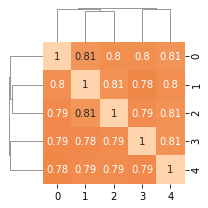

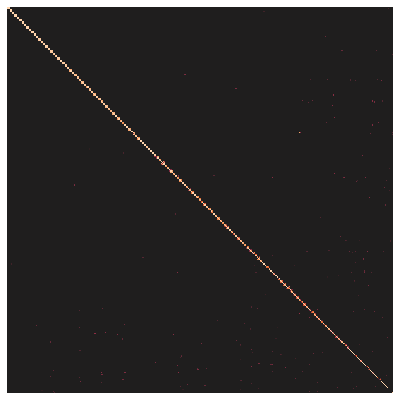

79 s for similarity matrix
	Running Louvain ...
		modularity: potts
	curve type: increasing


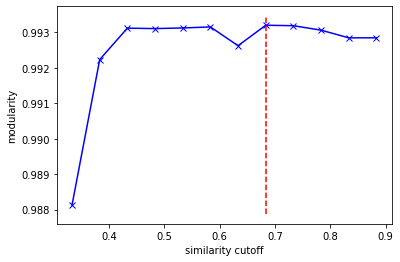

	Louvain runtime: modules detected in 0.78 s.
	modules: 180, not clustered features 72 
		similarity cutoff: 0.68 modularity: 0.993
keep genes included in at least 2 merged biclusters


In [ ]:
consensus_biclusters2 = make_consensus_biclusters(biclustering_results, 
                                                  zscore(exprs_m), 
                                                  seed = cseed,
                                                  verbose = True,
                                                  plot = True)


In [ ]:
outfname = out_dir+"/"+dataset+".consensus_v2_seed="+str(cseed)+suffix
print(outfname)
write_bic_table(consensus_biclusters2, outfname)

In [ ]:
exprs_file_m = "data/preprocessed_v6/METABRIC_1904_17Kgenes.log2_exprs_z_v6.tsv"
exprs_m= pd.read_csv(exprs_file_m,sep = "\t",index_col=0)

m_subtypes = pd.read_csv("data/preprocessed_v6/METABRIC_1904_17Kgenes.subtypes_and_signatures_v6.tsv",sep = "\t",index_col=0)
m_annotation = pd.read_csv("data/preprocessed_v6/METABRIC_1904.annotation_v6.tsv",sep = "\t",index_col=0)

known_groups_m, all_samples_m = make_ref_groups(m_subtypes, m_annotation,exprs_m)

In [ ]:
performances2, best_matches2 = calculate_perfromance(consensus_biclusters2, known_groups_m,all_samples_m,
                                                  performance_measure="ARI")
performances2

In [ ]:
best_matches2.head()

### Her2, Basal, Luminal

In [ ]:
from unpast.utils.figs import draw_heatmap2
from unpast.utils.method import  prepare_input_matrix

bm = best_matches2.loc[best_matches2["classification"]=="PAM50",:]
i = [bm.loc["Her2","bm_id"],bm.loc["Basal","bm_id"],bm.loc["Luminal","bm_id"]]

tmp = draw_heatmap2(prepare_input_matrix(exprs_m, min_n_samples=5,ceiling=3),
                    consensus_biclusters2.loc[i,:],
                    annot = m_subtypes.loc[:,["PAM50"]],
                    color_dict= color_dict,
              bicluster_colors=["yellow","lightblue","springgreen"],#"redblue",#["magenta","orange","darkgreen","lightgreen"],
              figsize = (12,6), 
              dendrogram_ratio=(0.1,0.1),
              colors_ratio=(0.02/12*6, 0.02),
              bic_prefix = "b. ",
              no_legend=True,no_cbar=True,
              col_labels = False,
              row_labels = False,
                no_row_colors = False,cluster_rows=False
             )

#plt.savefig("img/METABRIC_consensus_PAM50_bestmatches.biclusters.pdf")

### Normal-like, LumA, LumB

In [ ]:
bm = best_matches2.loc[best_matches2["classification"]=="PAM50_AB",:]
i = [bm.loc["Normal","bm_id"],bm.loc["LumA","bm_id"],bm.loc["LumB","bm_id"]]
b = consensus_biclusters2.loc[i,:]

exprs_z = prepare_input_matrix(exprs_m, min_n_samples=5,ceiling=3)
tmp = draw_heatmap2(exprs_z ,b,
                    annot = m_subtypes.loc[:,["PAM50"]],
                    color_dict= color_dict,
              bicluster_colors=["grey","lightgreen","darkgreen"],#"redblue",#["magenta","orange","darkgreen","lightgreen"],
              figsize = (12,6), 
              dendrogram_ratio=(0.1,0.1),
              colors_ratio=(0.02/12*6, 0.02),
              bic_prefix = "b. ",
              no_legend=True,no_cbar=True,
              col_labels = False,
              row_labels = True,
                no_row_colors = False,cluster_rows=False
             )